In [2]:
# Importar librerias

# Liberías para análisis geoespacial y manejo de datos
import pandas as pd
import geopandas as gpd 
import numpy as np

# Liberías para manejo y análisis de datos vector y raster
import rasterio 
from rasterio.mask import mask
from shapely.geometry import mapping, box
import os

# Librerías para visualización de mapas y datos geoespaciales
import contextily as ctx
import matplotlib.pyplot as plt

# Librerías necesarias Modelo Poisson
import statsmodels.api as sm
import statsmodels.formula.api as smf

* Grados (°):
Son la unidad básica para medir ángulos, y se utilizan para indicar la latitud y longitud de un lugar en la Tierra.
* Minutos ('):
Un grado se divide en 60 minutos, lo que significa que 1° = 60'.
* Kilómetros (km):
En el Ecuador, un grado de longitud equivale a aproximadamente 111,32 km. Un minuto de longitud, por otro lado, equivale a aproximadamente 1,85 km. 
* Equivalencia:
Esta equivalencia es importante para entender la extensión real de un ángulo en grados, minutos y segundos en la superficie terrestre. 


Importamos datos raster (.tif)
### Datos WorldClim
Estos son los datos climáticos de WorldClim versión 2.1 para el período 1970-2000. Esta versión se publicó en enero de 2020. Los datos están en resoluciones espaciales de 2.5m (~21.4 km²).

* Variables bioclimáticas: Se incluyen datos de 19 variables bioclimáticas.
Las variables bioclimáticas representan tendencias anuales (p. ej., temperatura media anual, precipitación anual), estacionalidad (p. ej., amplitud térmica anual) y factores ambientales extremos o limitantes (p. ej., temperatura del mes más frío y más cálido, y precipitación de los trimestres húmedo y seco). Un trimestre es un período de tres meses (1/4 del año).

Se codifican de la siguiente manera:

BIO1 = Temperatura media anual

BIO2 = Rango medio diurno (Media mensual (temperatura máxima - temperatura mínima))

BIO3 = Isotermalidad (BIO2/BIO7) (×100)

BIO4 = Estacionalidad de la temperatura (desviación estándar ×100)

BIO5 = Temperatura máxima del mes más cálido

BIO6 = Temperatura mínima del mes más frío

BIO7 = Rango anual de temperatura (BIO5-BIO6)

BIO8 = Temperatura media del trimestre más húmedo

BIO9 = Temperatura media del trimestre más seco

BIO10 = Temperatura media del trimestre más cálido

BIO11 = Temperatura media del trimestre más frío

BIO12 = Precipitación anual

BIO13 = Precipitación del mes más lluvioso

BIO14 = Precipitación del mes más seco

BIO15 = Estacionalidad de la precipitación (coeficiente de variación)

BIO16 = Precipitación del trimestre más húmedo

BIO17 = Precipitación del trimestre más seco

BIO18 = Precipitación del trimestre más cálido

BIO19 = Precipitación del trimestre más frío

Este esquema sigue al de ANUCLIM, excepto que para la estacionalidad de la temperatura se utilizó la desviación estándar porque un coeficiente de variación no tiene sentido con temperaturas entre -1 y 1).

* Utilizando datos de entre 9000 y 60 000 estaciones meteorológicas. Los datos de las estaciones meteorológicas se interpolaron utilizando splines de placa delgada con covariables que incluían elevación, distancia a la costa y tres covariables derivadas de satélite: temperatura máxima y mínima de la superficie terrestre, así como cobertura de nubes, obtenidas con la plataforma satelital MODIS. 

* Fick, S.E. and R.J. Hijmans, 2017. WorldClim 2: new 1km spatial resolution climate surfaces for global land areas. International Journal of Climatology 37 (12): 4302-4315.

In [6]:
# Descomprimir el archivo ZIP que contiene los archivos .tif
import zipfile
import os

# 1. Ruta al archivo zip y carpeta de destino
# reemplaza con tu ruta
zip_files  = (r"G:\My Drive\Investigacion2025\Posgrado_Statistics\GeoAnalysis\data\wc2.1_2.5m_bio.zip",
r"G:\My Drive\Investigacion2025\Posgrado_Statistics\GeoAnalysis\data\wc2.1_2.5m_elev.zip")
extract_folder1 = r"G:\My Drive\Investigacion2025\Posgrado_Statistics\GeoAnalysis\data\wc_2.5m"   # carpeta donde extraerás los .tif

# 2. Extraer cada .zip en la misma carpeta
for zip_path in zip_files:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder1)

Importamos máscara

C:\Users\Valentina Cardona\AppData\Local\Temp\ipykernel_25924\4286865330.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geometry=[departamentos.unary_union],


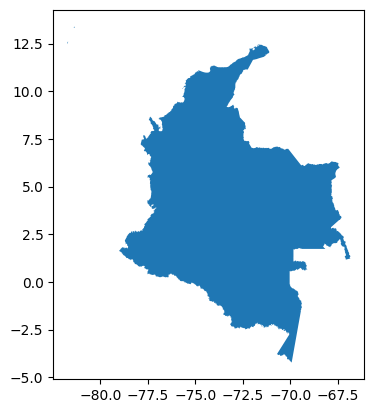

In [7]:
# Usamos el shape de departamentos de Colombia para hacer de máscara
departamentos = gpd.read_file(r"G:\My Drive\Investigacion2025\Posgrado_Statistics\GeoAnalysis\data\Departamentos_COL.shp")
departamentos = departamentos.to_crs(epsg=4326) 

# Unir todos los polígonos de departamentos en uno solo
silueta_COL = gpd.GeoDataFrame(
    geometry=[departamentos.unary_union],
    crs=departamentos.crs)

silueta_COL.plot()
# Obtener la geometría de la silueta
mask_geom = [mapping(silueta_COL.iloc[0].geometry)]

Recortamos los archivos .tif usando la silueta de Departamentos

In [8]:
# Máscara y recorte de los archivos .tif
extract_folder2 = r"G:\My Drive\Investigacion2025\Posgrado_Statistics\GeoAnalysis\data\clipped_wc_2.5m"
os.makedirs(extract_folder2, exist_ok=True)  # Crea la carpeta si no existe

# Iterar sobre los archivos .tif
for file in os.listdir(extract_folder1):
    if file.endswith('.tif'):
        tif_path = os.path.join(extract_folder1, file)

        with rasterio.open(tif_path) as src:
            # Aplicar máscara (asegúrate de definir 'mask_geom' antes)
            clipped_array, clipped_transform = mask(src, mask_geom, crop=True)
            # Copiar y actualizar metadatos
            out_meta = src.meta.copy()
            out_meta.update({
                "driver": "GTiff",
                "height": clipped_array.shape[1],
                "width": clipped_array.shape[2],
                "transform": clipped_transform})
            # Ruta y nombre del archivo de salida
            out_tif = os.path.join(extract_folder2, f"clipped_{file}")
            with rasterio.open(out_tif, "w", **out_meta) as dest:
                dest.write(clipped_array)

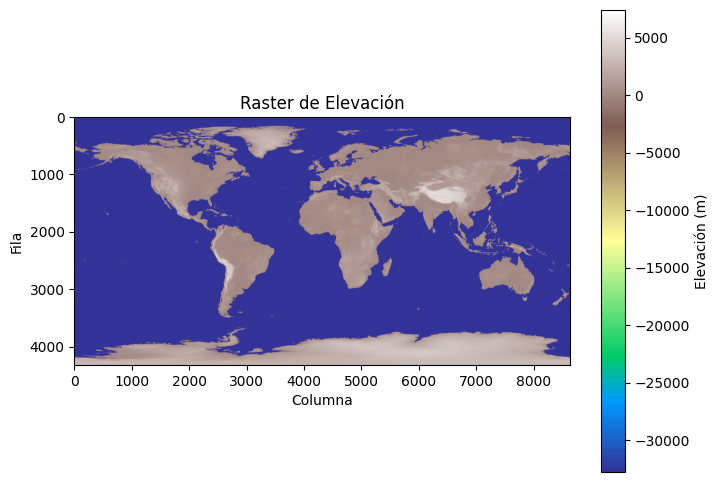

In [9]:
# Abrir el raster
elev = rasterio.open(r"G:\My Drive\Investigacion2025\Posgrado_Statistics\GeoAnalysis\data\wc_2.5m\wc2.1_2.5m_elev.tif")

# Leer la primera banda
elev_data = elev.read(1)

# Graficar el raster
plt.figure(figsize=(8, 6))
plt.imshow(elev_data, cmap='terrain')
plt.colorbar(label='Elevación (m)')
plt.title('Raster de Elevación')
plt.xlabel('Columna')
plt.ylabel('Fila')
plt.show()


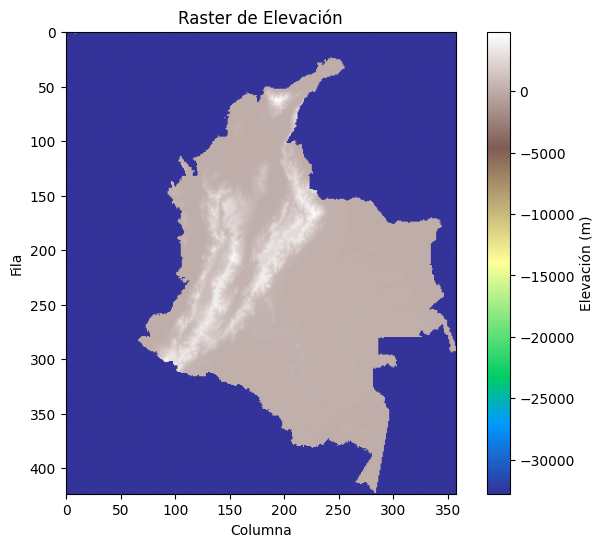

In [11]:
# Abrir el raster
elev = rasterio.open(r"G:\My Drive\Investigacion2025\Posgrado_Statistics\GeoAnalysis\data\clipped_wc_2.5m\clipped_wc2.1_2.5m_elev.tif")

# Leer la primera banda
elev_data = elev.read(1)

# Graficar el raster
plt.figure(figsize=(8, 6))
plt.imshow(elev_data, cmap='terrain')
plt.colorbar(label='Elevación (m)')
plt.title('Raster de Elevación')
plt.xlabel('Columna')
plt.ylabel('Fila')
plt.show()

Importamos los datos de balso. Datos GBIF 

In [143]:
# Leer base de datos
data = pd.read_csv(
    r"G:\My Drive\Investigacion2025\Posgrado_Statistics\GeoAnalysis\data\GBIF_data.csv",
    sep="\t",
    encoding="utf-8")

# Renombrar columnas para facilitar el manejo
data = data.rename(columns={'decimalLatitude': 'latitude', 
                            'decimalLongitude': 'longitude'})

# Solo seleccionar las columnas necesarias
data = data[['latitude', 'longitude', 'species']]

# Convertir tu DataFrame a GeoDataFrame
data_gdf = gpd.GeoDataFrame(
    data, 
    geometry=gpd.points_from_xy(data['longitude'], data['latitude']),
    crs="EPSG:4326"  # WGS84
)

## Creamos Dataframe con:
- Y1=data count. Cantidad de datos por grilla. La grilla tiene las dimensiones de la resolución del pixel de los raster .tif (2.5min=4.625kmx4.625km =21.390km2)


In [66]:
import os
import rasterio
from shapely.geometry import box

# Asume que data_gdf ya está definido y tiene los puntos de interés
extract_folder2 = r"G:\My Drive\Investigacion2025\Posgrado_Statistics\GeoAnalysis\data\clipped_wc_2.5m"

# Usar el primer archivo .tif para definir la grilla base
tif_files = [f for f in os.listdir(extract_folder2) if f.endswith('.tif')]
base_tif = os.path.join(extract_folder2, tif_files[0])

with rasterio.open(base_tif) as elev:
    width = elev.width
    height = elev.height
    transform = elev.transform

    Y1 = []
    quad_geoms = []

    for row in range(height):
        for col in range(width):
            x_min, y_max = transform * (col, row)
            x_max, y_min = transform * (col + 1, row + 1)
            quad = box(x_min, y_min, x_max, y_max)
            quad_geoms.append(quad)
            count = data_gdf.within(quad).sum()
            Y1.append(count)

# Crear DataFrame base con la grilla y data_count
df = gpd.GeoDataFrame({'data_count': Y1, 'geometry': quad_geoms}, crs="EPSG:4326")

# Para cada archivo .tif, agrega una columna con los valores de ese raster
for tif_file in tif_files:
    tif_path = os.path.join(extract_folder2, tif_file)
    col_name = f"{os.path.splitext(tif_file)[0]}"  # Nombre de la columna basado en el nombre del archivo
    with rasterio.open(tif_path) as src:
        arr = src.read(1)
        nodata = src.nodata
        # Si hay nodata, reemplaza por np.nan
        if nodata is not None:
            arr = np.where(arr == nodata, np.nan, arr)
        df[col_name] = arr.flatten()

# Filtrar solo los píxeles con al menos un punto
df_filtered = df[df['data_count'] > 0].copy()

In [144]:
# Convertir tu DataFrame a GeoDataFrame
df_filtered_gdf = gpd.GeoDataFrame(
    df_filtered, 
    geometry='geometry',
    crs="EPSG:4326"  # WGS84
)

In [134]:
#Agregamos el nombre del departamento a cada celda de la grilla
import geopandas as gpd

# Realiza el join espacial (cada celda toma el atributo del polígono en el que cae)
df_filtered_gdf = gpd.sjoin(df_filtered_gdf, departamentos[['NOMBRE_DPT', 'geometry']], how='left', predicate='intersects')
# Renombra la columna si lo deseas
df_filtered_gdf = df_filtered_gdf.rename(columns={'NOMBRE_DPT': 'departamento'})
# Elimina la columna 'index_right' que se agrega por defecto en el join espacial
df_filtered_gdf = df_filtered_gdf.drop(columns='index_right')

In [135]:
# Renombrar columnas sin espacios, sin puntuación, usando `_`
df_filtered_gdf = df_filtered_gdf.rename(columns={
    'data_count': 'Conteo_de_datos',
    'clipped_wc2.1_2.5m_bio_1': 'Temperatura_media_anual',
    'clipped_wc2.1_2.5m_bio_2': 'Rango_medio_diurno',
    'clipped_wc2.1_2.5m_bio_3': 'Isotermalidad',
    'clipped_wc2.1_2.5m_bio_4': 'Estacionalidad_de_la_temperatura',
    'clipped_wc2.1_2.5m_bio_5': 'Temp_maxima_mes_mas_calido',
    'clipped_wc2.1_2.5m_bio_6': 'Temp_minima_mes_mas_frio',
    'clipped_wc2.1_2.5m_bio_7': 'Rango_anual_de_temperatura',
    'clipped_wc2.1_2.5m_bio_8': 'Temp_media_trimestre_mas_humedo',
    'clipped_wc2.1_2.5m_bio_9': 'Temp_media_trimestre_mas_seco',
    'clipped_wc2.1_2.5m_bio_10': 'Temp_media_trimestre_mas_calido',
    'clipped_wc2.1_2.5m_bio_11': 'Temp_media_trimestre_mas_frio',
    'clipped_wc2.1_2.5m_bio_12': 'Precipitacion_anual',
    'clipped_wc2.1_2.5m_bio_13': 'Precipitacion_mes_mas_lluvioso',
    'clipped_wc2.1_2.5m_bio_14': 'Precipitacion_mes_mas_seco',
    'clipped_wc2.1_2.5m_bio_15': 'Estacionalidad_de_la_precipitacion',
    'clipped_wc2.1_2.5m_bio_16': 'Precipitacion_trimestre_mas_humedo',
    'clipped_wc2.1_2.5m_bio_17': 'Precipitacion_trimestre_mas_seco',
    'clipped_wc2.1_2.5m_bio_18': 'Precipitacion_trimestre_mas_calido',
    'clipped_wc2.1_2.5m_bio_19': 'Precipitacion_trimestre_mas_frio',
    'clipped_wc2.1_2.5m_elev': 'Elevacion'
})

In [136]:
# Ocho  entradas tienen valores NaN en los datos de biovariables y elevación. Se eliminarán
print(df_filtered_gdf.isna().sum())
df_filtered_gdf[df_filtered_gdf.isna().any(axis=1)].head(8)

# Eliminar filas con NaN en la columna específica
df_filtered_gdf = df_filtered_gdf[~df_filtered_gdf['Temperatura_media_anual'].isna()].copy()

Conteo_de_datos                       0
geometry                              0
Temperatura_media_anual               0
Temp_media_trimestre_mas_calido       0
Temp_media_trimestre_mas_frio         0
Precipitacion_anual                   0
Precipitacion_mes_mas_lluvioso        0
Precipitacion_mes_mas_seco            0
Estacionalidad_de_la_precipitacion    0
Precipitacion_trimestre_mas_humedo    0
Precipitacion_trimestre_mas_seco      0
Precipitacion_trimestre_mas_calido    0
Precipitacion_trimestre_mas_frio      0
Rango_medio_diurno                    0
Isotermalidad                         0
Estacionalidad_de_la_temperatura      0
Temp_maxima_mes_mas_calido            0
Temp_minima_mes_mas_frio              0
Rango_anual_de_temperatura            0
Temp_media_trimestre_mas_humedo       0
Temp_media_trimestre_mas_seco         0
Elevacion                             0
departamento                          0
dtype: int64


In [137]:

df_filtered_gdf.describe()

,Conteo_de_datos,Temperatura_media_anual,Temp_media_trimestre_mas_calido,Temp_media_trimestre_mas_frio,Precipitacion_anual,Precipitacion_mes_mas_lluvioso,Precipitacion_mes_mas_seco,Estacionalidad_de_la_precipitacion,Precipitacion_trimestre_mas_humedo,Precipitacion_trimestre_mas_seco,...,Precipitacion_trimestre_mas_frio,Rango_medio_diurno,Isotermalidad,Estacionalidad_de_la_temperatura,Temp_maxima_mes_mas_calido,Temp_minima_mes_mas_frio,Rango_anual_de_temperatura,Temp_media_trimestre_mas_humedo,Temp_media_trimestre_mas_seco,Elevacion
count,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,...,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000
mean,17.026210,24.145447,24.703865,23.553881,2430.439453,333.270172,71.899193,44.482765,874.512085,283.098785,...,774.485901,9.649798,85.433815,46.797630,30.096991,18.748405,11.348586,23.770464,24.354708,727.227823
std,141.473277,3.460825,3.594246,3.388526,857.683167,96.341751,60.365738,13.359006,281.335571,194.920349,...,302.978210,0.947918,5.906331,23.226889,3.901471,3.315988,1.332059,3.415881,3.564476,650.263753
min,1.000000,10.758667,11.124666,10.536000,938.000000,138.000000,4.000000,10.752943,355.000000,19.000000,...,30.000000,6.738333,64.815857,17.718084,16.104000,4.964000,7.615999,10.702666,10.556000,6.000000
25%,1.000000,22.292209,22.683166,21.754000,1885.500000,258.000000,36.000000,34.363449,656.000000,181.750000,...,607.000000,9.035917,81.538385,31.580967,27.893000,16.846000,10.454999,21.937333,22.411001,160.500000
50%,1.000000,25.109917,25.848666,24.372666,2385.000000,325.000000,61.500000,43.717913,843.000000,259.500000,...,711.500000,9.646333,87.136456,39.224276,30.870000,19.706000,11.492001,24.722667,25.534666,532.000000
75%,3.000000,26.836292,27.689166,26.301834,2736.000000,391.000000,91.250000,53.472844,1026.000000,336.250000,...,979.250000,10.363334,89.919189,51.812424,33.426001,21.349999,12.351999,26.601833,27.255667,1129.750000
max,2771.000000,28.611500,29.299999,28.104666,7060.000000,752.000000,443.000000,84.500862,2195.000000,1456.000000,...,1985.000000,11.796000,93.807396,129.204926,35.908001,23.096001,15.067997,28.420666,28.834667,3107.000000


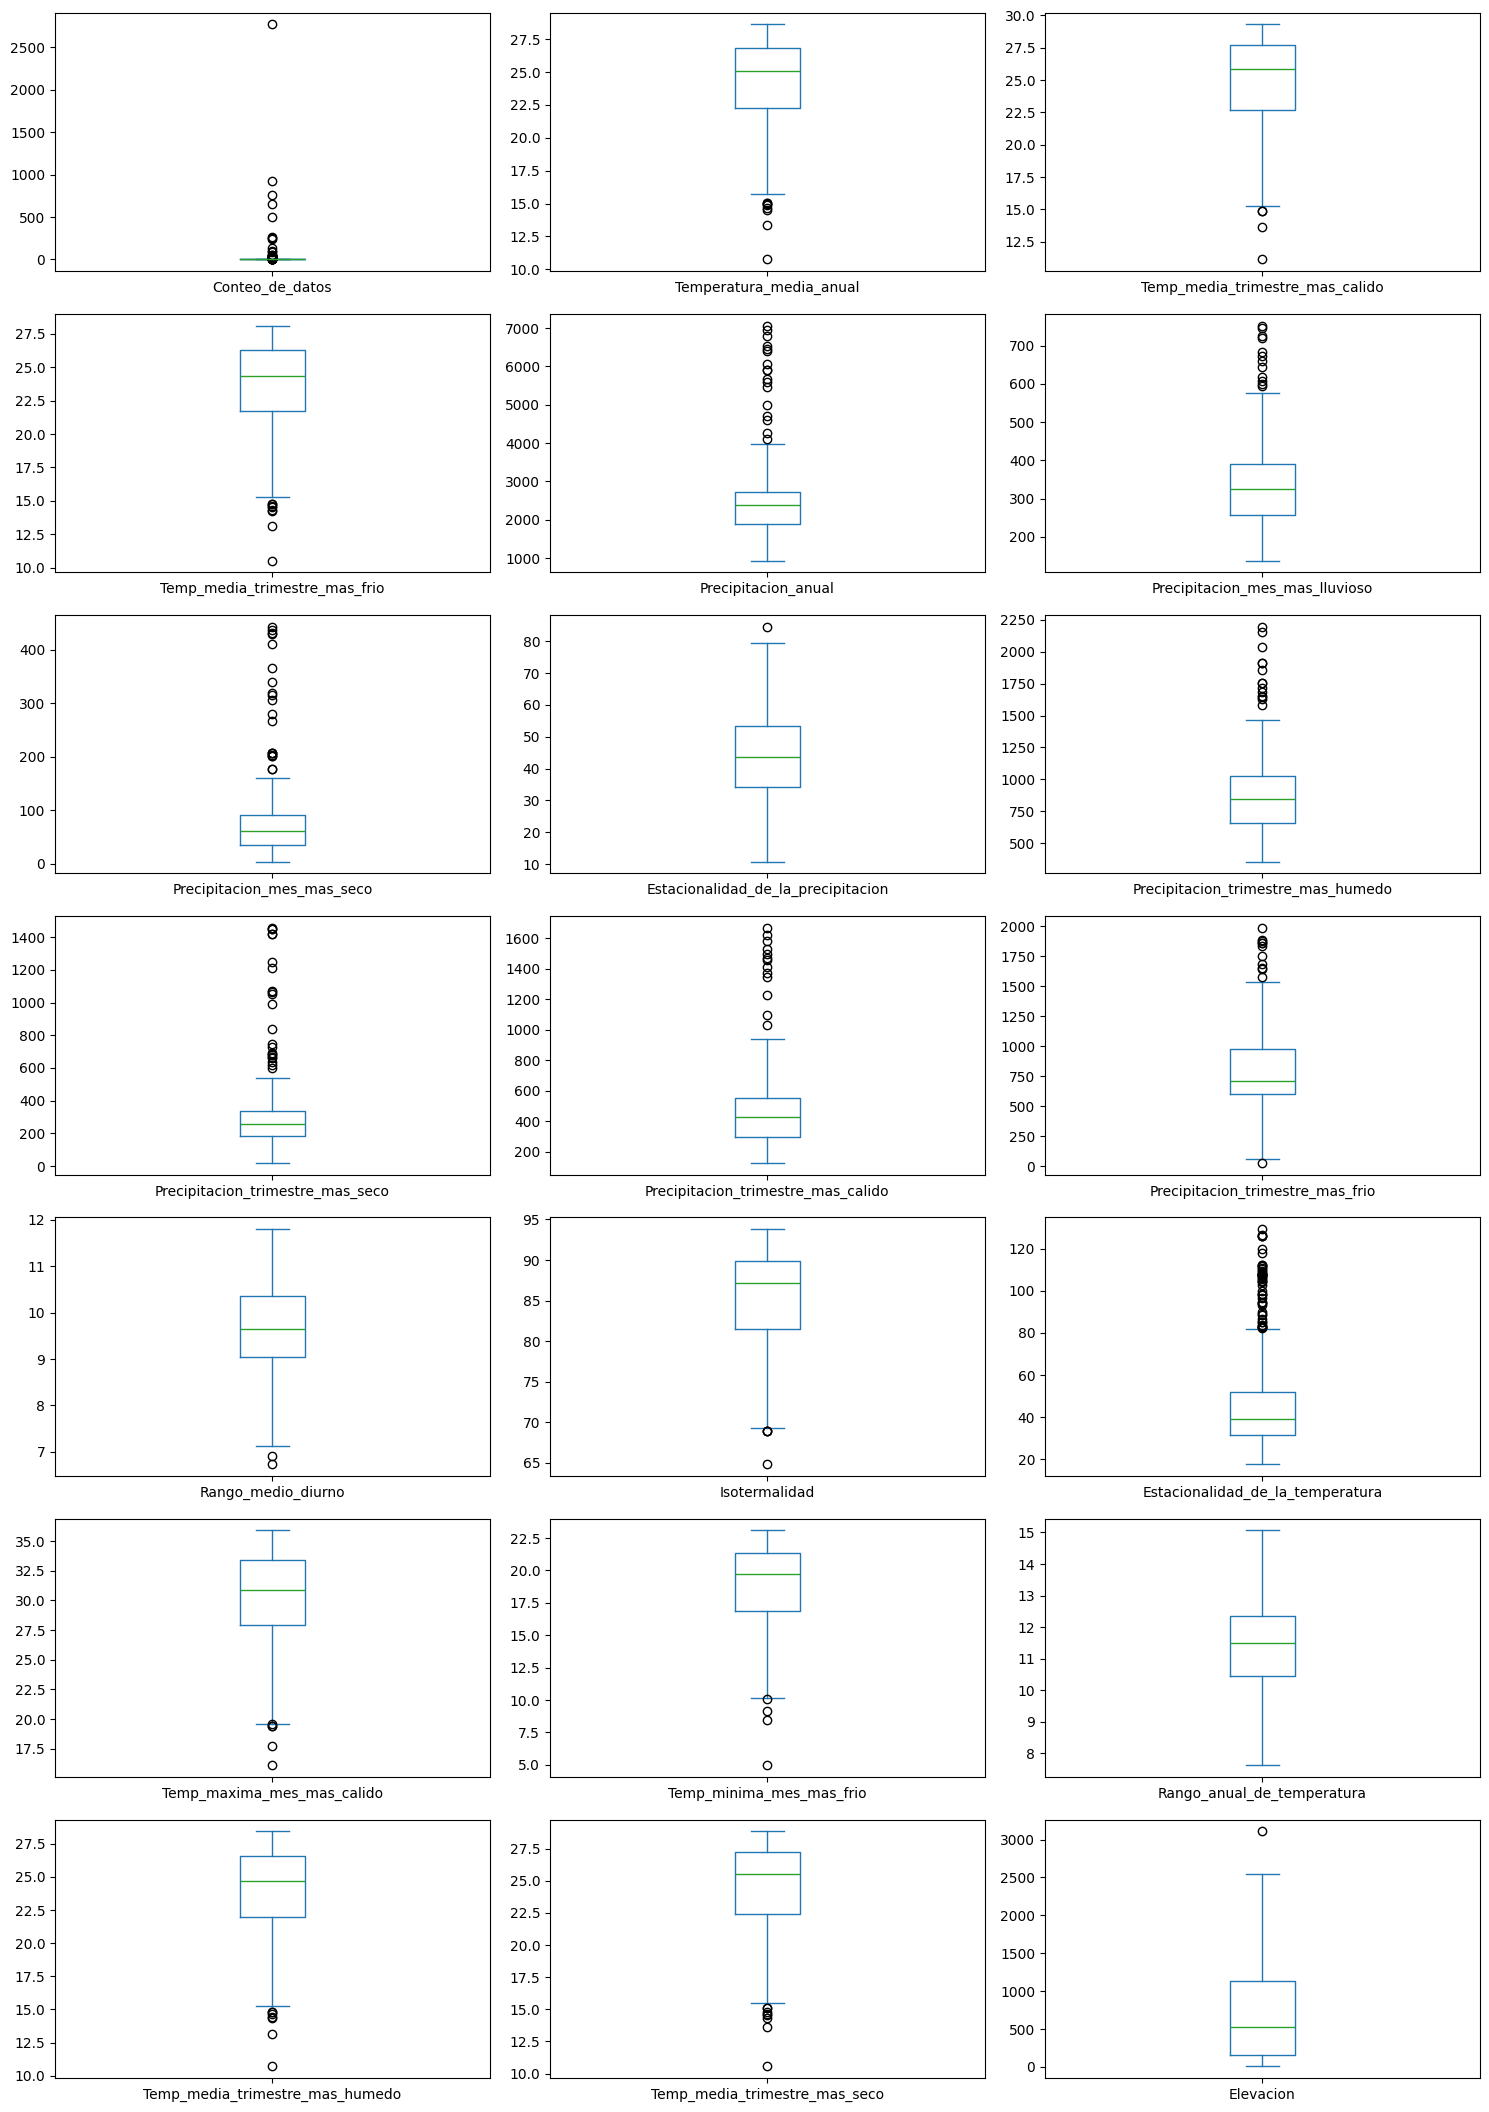

In [138]:
import matplotlib.pyplot as plt

# Selecciona solo las columnas numéricas (excluye 'geometry' si existe)
cols = [col for col in df_filtered_gdf.columns if col != 'geometry']
df_num = df_filtered_gdf[cols]

# Crea un boxplot para cada columna numérica
df_num.plot(kind='box', subplots=True, layout=(int(np.ceil(len(cols)/3)), 3), figsize=(15, 3*int(np.ceil(len(cols)/3))), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

Filtro ecológico. La especie es de baja elevación. Revisamos las entradas con elevación mayor a 2000m y si es oportuno se remueven. 

In [139]:
# Revisar todas las entradas con elevación mayor a 2100m
(df_filtered_gdf['Elevacion']> 2100).sum() #13 entradas

np.int64(16)

In [140]:
# Eliminar filas donde la elevación es mayor a 2100
df_filtered_gdf = df_filtered_gdf[df_filtered_gdf['Elevacion'] <= 2100].copy()

In [141]:
df_filtered_gdf.head(3)

,Conteo_de_datos,geometry,Temperatura_media_anual,Temp_media_trimestre_mas_calido,Temp_media_trimestre_mas_frio,Precipitacion_anual,Precipitacion_mes_mas_lluvioso,Precipitacion_mes_mas_seco,Estacionalidad_de_la_precipitacion,Precipitacion_trimestre_mas_humedo,...,Rango_medio_diurno,Isotermalidad,Estacionalidad_de_la_temperatura,Temp_maxima_mes_mas_calido,Temp_minima_mes_mas_frio,Rango_anual_de_temperatura,Temp_media_trimestre_mas_humedo,Temp_media_trimestre_mas_seco,Elevacion,departamento
18441,2,"POLYGON ((-74.08333 11.25, -74.08333 11.29167,...",27.127834,27.808666,26.400667,997.0,235.0,4.0,84.500862,502.0,...,8.456334,80.999359,57.117706,31.916000,21.476000,10.440001,26.941334,26.617332,193.0,MAGDALENA
18446,2,"POLYGON ((-73.875 11.25, -73.875 11.29167, -73...",27.071354,27.765972,26.270138,977.0,219.0,13.0,75.441505,504.0,...,8.714236,79.733780,60.469223,32.145832,21.216667,10.929165,26.957638,26.482639,150.0,MAGDALENA
18812,1,"POLYGON ((-73.54167 11.20833, -73.54167 11.25,...",27.396000,28.190001,26.553333,938.0,208.0,14.0,76.452286,485.0,...,9.143333,79.121948,65.497215,32.880001,21.323999,11.556002,27.237333,26.808666,105.0,MAGDALENA


In [ ]:
# Guardar el DataFrame filtrado como un archivo CSV
#df_filtered_gdf.to_csv(r"G:\My Drive\Investigacion2025\Posgrado_Statistics\GeoAnalysis\data\df_filtered_gdf.csv", index=False)

# Para cargarlos después, puedes usar:
#df_filtered_gdf = pd.read_csv(r"G:\My Drive\Investigacion2025\Posgrado_Statistics\GeoAnalysis\data\df_filtered_gdf.csv")

# Modelo Lineal Generalizado de Poisson

* GLM de Poisson homogéneo

La distribución de Poisson describe la probabilidad de que un número de eventos Y ocurra en un intervalo de tiempo o una región espacial dada, si esos eventos suceden con una tasa constante λ. Supongamos que estamos analizando la cantidad de “observación de Balso” en diferentes celdas de una cuadrícula de 2.5min. Queremos modelar cómo ciertos factores ambientales afectan el número de observaciones de Balso en cada celda. Utilizaremos un modelo de Poisson para modelar el número de observación en función de estas covariables.

Si un proceso de puntos de Poisson tiene un parámetro constante λ, entonces se llama proceso de Poisson homogéneo (o estacionario) (HPP). Una generalización del HPP que permite una intensidad no constante (λ),se llama proceso de Poisson no-homogéneo (IPP), varía espacialmente λ=Z(u) 

Proceso de Poisson espacial homogéneno con parámetro λ, describe la probabilidad de que existan (n) puntos en la región acotada A, mediante:
$P\{N(A) = n\} = \frac{\lambda^{|A|} (|A|)^n}{n!} e^{-\lambda |A|}$

In [121]:
df_filtered_gdf.describe()

,Conteo_de_datos,Temperatura_media_anual,Temp_media_trimestre_mas_calido,Temp_media_trimestre_mas_frio,Precipitacion_anual,Precipitacion_mes_mas_lluvioso,Precipitacion_mes_mas_seco,Estacionalidad_de_la_precipitacion,Precipitacion_trimestre_mas_humedo,Precipitacion_trimestre_mas_seco,...,Precipitacion_trimestre_mas_frio,Rango_medio_diurno,Isotermalidad,Estacionalidad_de_la_temperatura,Temp_maxima_mes_mas_calido,Temp_minima_mes_mas_frio,Rango_anual_de_temperatura,Temp_media_trimestre_mas_humedo,Temp_media_trimestre_mas_seco,Elevacion
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,...,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,17.554167,24.445843,25.013588,23.846062,2442.322998,335.335419,71.222916,44.873611,881.556274,281.452087,...,780.716675,9.689032,85.295067,47.455654,30.437765,19.026991,11.410772,24.064077,24.662373,673.954167
std,143.786555,3.083803,3.210474,3.025304,865.157654,96.676125,60.885345,13.363391,282.214508,196.940964,...,304.538635,0.935278,5.922855,23.320192,3.473341,2.976412,1.300861,3.052503,3.180894,588.885900
min,1.000000,16.271999,16.430666,15.476667,938.000000,172.000000,4.000000,10.752943,451.000000,19.000000,...,30.000000,6.738333,64.815857,17.718084,21.304001,10.128000,7.615999,16.028667,15.476667,6.000000
25%,1.000000,22.529416,22.952166,21.993499,1894.750000,258.000000,36.000000,34.622633,657.000000,178.500000,...,608.500000,9.140417,81.437342,32.497666,28.343999,17.120000,10.556000,22.183333,22.690166,156.750000
50%,1.000000,25.260667,26.016999,24.501000,2404.500000,326.500000,60.000000,44.101820,847.000000,257.000000,...,721.000000,9.670333,86.946362,39.567982,31.066000,19.823999,11.530000,24.894667,25.681001,485.500000
75%,3.000000,26.856041,27.741333,26.326167,2748.750000,393.250000,90.250000,53.973514,1032.250000,335.000000,...,985.250000,10.382999,89.873173,53.566715,33.523000,21.385999,12.383998,26.676001,27.307167,1075.250000
max,2771.000000,28.611500,29.299999,28.104666,7060.000000,752.000000,443.000000,84.500862,2195.000000,1456.000000,...,1985.000000,11.796000,93.807396,129.204926,35.908001,23.096001,15.067997,28.420666,28.834667,2095.000000


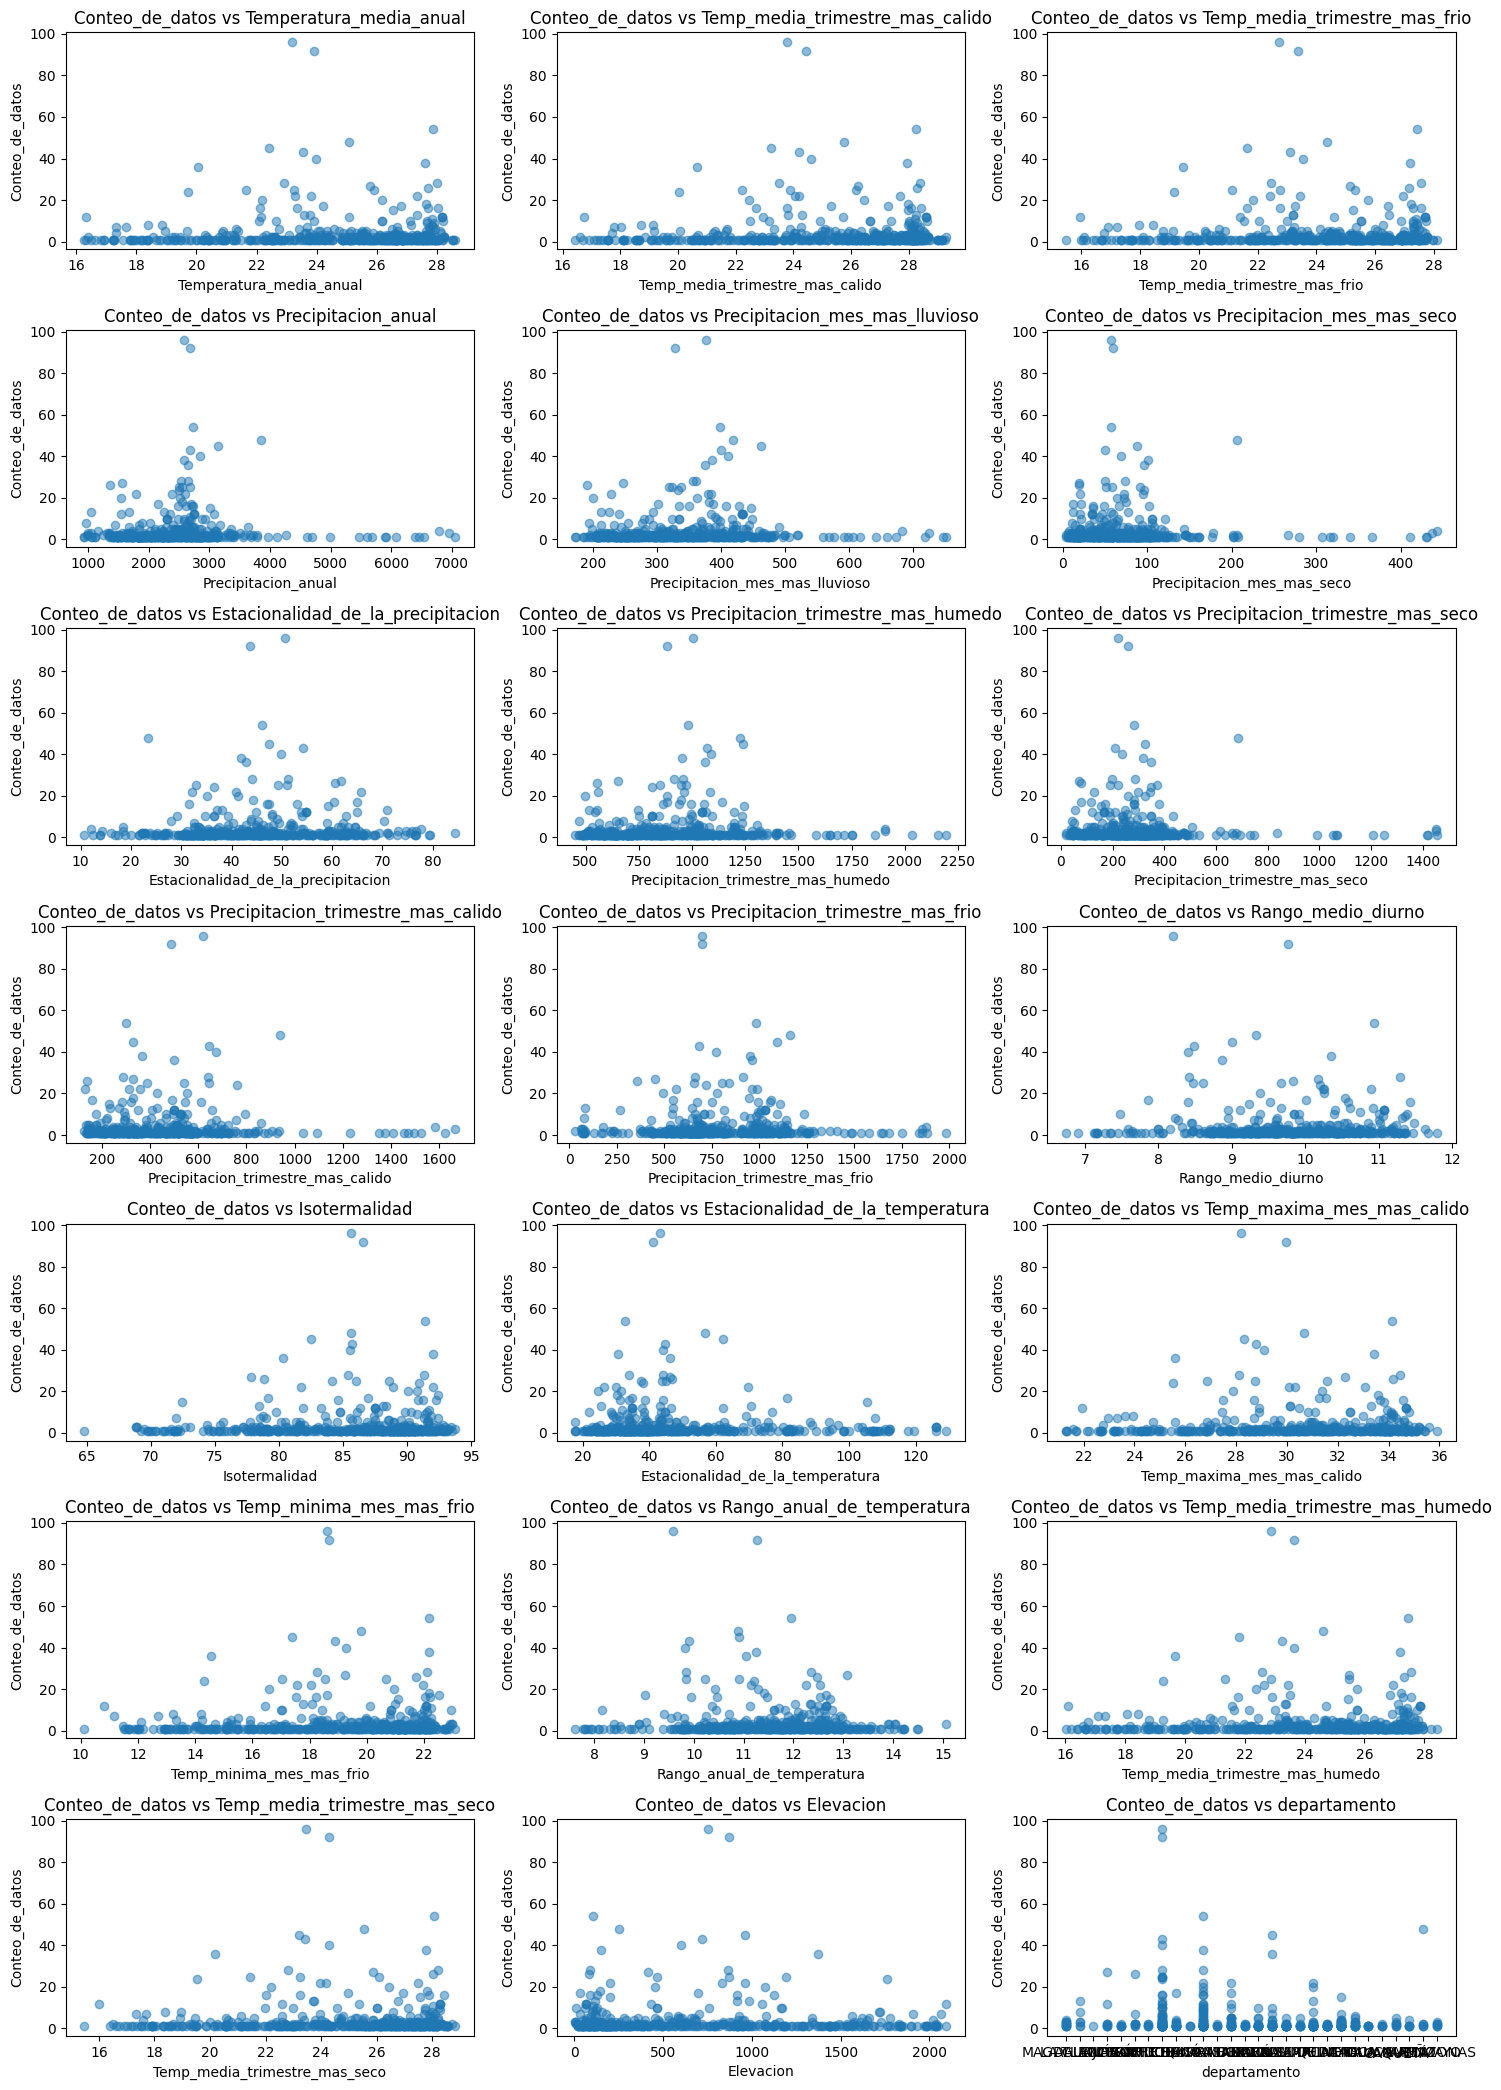

In [122]:
import matplotlib.pyplot as plt

# Scatter plots para explorar la relación entre 'Conteo_de_datos' y las variables numéricas

# Para poder ver algun patrón, filtrar los datos donde Conteo_de_datos < 100
df_small_counts = df_filtered_gdf[df_filtered_gdf['Conteo_de_datos'] < 100].copy()


# Selecciona solo las columnas numéricas excepto 'Conteo_de_datos' y 'geometry'
variables = [col for col in df_small_counts.columns if col not in ['Conteo_de_datos', 'geometry']]
n_vars = len(variables)

# Definir la organización de los subplots
ncols = 3
nrows = int(np.ceil(n_vars / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3 * nrows))
axes = axes.flatten()

for i, var in enumerate(variables):
    axes[i].scatter(df_small_counts[var], df_small_counts['Conteo_de_datos'], alpha=0.5)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Conteo_de_datos')
    axes[i].set_title(f'Conteo_de_datos vs {var}')

# Eliminar ejes vacíos si hay menos variables que subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

* Modelo general (Con las 19 biovariables y la elevación)

In [124]:
df_filtered_gdf.columns

Index(['Conteo_de_datos', 'geometry', 'Temperatura_media_anual',
       'Temp_media_trimestre_mas_calido', 'Temp_media_trimestre_mas_frio',
       'Precipitacion_anual', 'Precipitacion_mes_mas_lluvioso',
       'Precipitacion_mes_mas_seco', 'Estacionalidad_de_la_precipitacion',
       'Precipitacion_trimestre_mas_humedo',
       'Precipitacion_trimestre_mas_seco',
       'Precipitacion_trimestre_mas_calido',
       'Precipitacion_trimestre_mas_frio', 'Rango_medio_diurno',
       'Isotermalidad', 'Estacionalidad_de_la_temperatura',
       'Temp_maxima_mes_mas_calido', 'Temp_minima_mes_mas_frio',
       'Rango_anual_de_temperatura', 'Temp_media_trimestre_mas_humedo',
       'Temp_media_trimestre_mas_seco', 'Elevacion', 'departamento'],
      dtype='object')

In [125]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# Lista de columnas predictoras (excluyendo Conteo_de_datos y geometry)
predictoras = [col for col in df_filtered_gdf.columns if col not in ['Conteo_de_datos', 'geometry', 'departamento']]

# Construir la fórmula
formula = "Conteo_de_datos ~ " + " + ".join(predictoras)

# Ajustar el modelo Poisson
modelo_poisson = smf.glm(formula=formula, 
                         data=df_filtered_gdf, 
                         family=sm.families.Poisson()).fit()

# Resumen del modelo
print(modelo_poisson.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        Conteo_de_datos   No. Observations:                  480
Model:                            GLM   Df Residuals:                      460
Model Family:                 Poisson   Df Model:                           19
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7597.4
Date:                Mon, 16 Jun 2025   Deviance:                       13894.
Time:                        17:19:36   Pearson chi2:                 9.85e+05
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

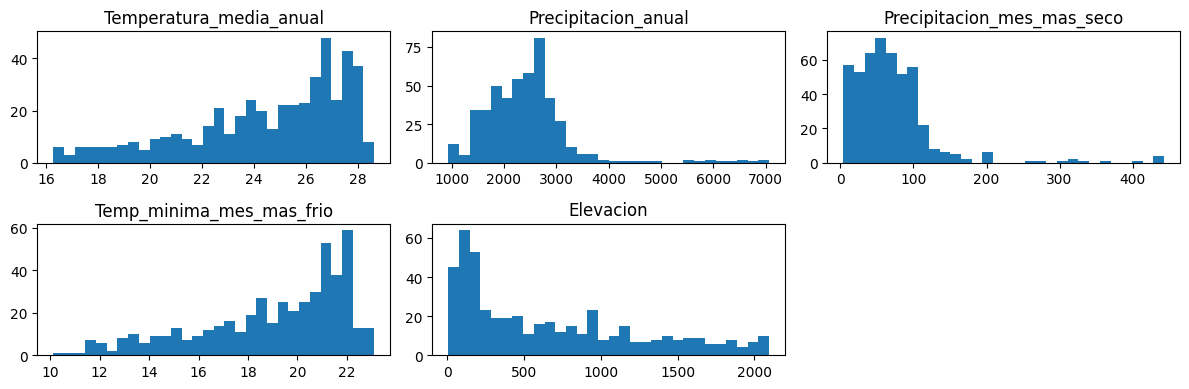

In [127]:
import matplotlib.pyplot as plt

variables = ['Temperatura_media_anual',
       'Precipitacion_anual', 
       'Precipitacion_mes_mas_seco', 
       'Temp_minima_mes_mas_frio',
       'Elevacion']

df_filtered_gdf[variables].hist(bins=30, figsize=(12, 4), layout=(2, 3), grid=False)
plt.tight_layout()
plt.show()

In [128]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# Lista de columnas predictoras (excluyendo Conteo_de_datos y geometry)
predictoras = ['Temperatura_media_anual',
       'Precipitacion_anual', 
       'Precipitacion_mes_mas_seco', 
       'Temp_minima_mes_mas_frio',
       'Elevacion']

# Estandariza las variables predictoras
scaler = StandardScaler()
df_scaled = df_filtered_gdf.copy()
df_scaled[predictoras] = scaler.fit_transform(df_filtered_gdf[predictoras])

# Construir la fórmula
formula = "Conteo_de_datos ~ " + " + ".join(predictoras)

# Ajustar el modelo Poisson
modelo_poisson = smf.glm(formula=formula, 
                         data=df_scaled, 
                         family=sm.families.Poisson()).fit()

# Resumen del modelo
print(modelo_poisson.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        Conteo_de_datos   No. Observations:                  480
Model:                            GLM   Df Residuals:                      474
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18584.
Date:                Mon, 16 Jun 2025   Deviance:                       35867.
Time:                        17:22:06   Pearson chi2:                 4.99e+05
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Implementacion del modelo Poisson por departamentos de Colombia

In [129]:
df_filtered_gdf.columns

Index(['Conteo_de_datos', 'geometry', 'Temperatura_media_anual',
       'Temp_media_trimestre_mas_calido', 'Temp_media_trimestre_mas_frio',
       'Precipitacion_anual', 'Precipitacion_mes_mas_lluvioso',
       'Precipitacion_mes_mas_seco', 'Estacionalidad_de_la_precipitacion',
       'Precipitacion_trimestre_mas_humedo',
       'Precipitacion_trimestre_mas_seco',
       'Precipitacion_trimestre_mas_calido',
       'Precipitacion_trimestre_mas_frio', 'Rango_medio_diurno',
       'Isotermalidad', 'Estacionalidad_de_la_temperatura',
       'Temp_maxima_mes_mas_calido', 'Temp_minima_mes_mas_frio',
       'Rango_anual_de_temperatura', 'Temp_media_trimestre_mas_humedo',
       'Temp_media_trimestre_mas_seco', 'Elevacion', 'departamento'],
      dtype='object')

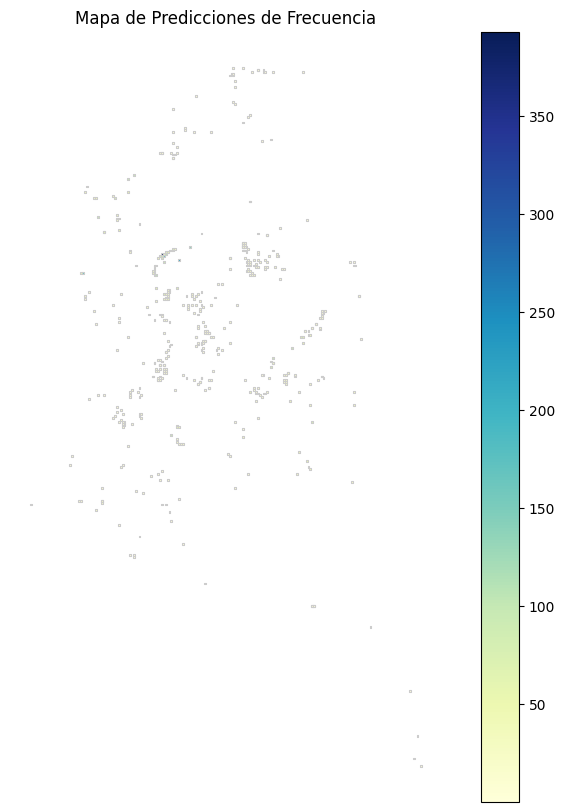

In [131]:
# Obtener las predicciones de frecuencia (ahora representan la frecuencia ajustada por el área)
y_pred_count = modelo_poisson.predict(df_scaled)

# Añadir las predicciones al GeoDataFrame
df_filtered_gdf['predicted_Conteo'] = y_pred_count

# Calcular la diferencia entre el valor real y la predicción con offset
df_filtered_gdf['difference_Conteo'] = df_filtered_gdf['Conteo_de_datos'] - df_filtered_gdf['predicted_Conteo']

# Graficar el mapa con los valores de predicción de frecuencia ajustados por área
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
df_filtered_gdf.plot(column='predicted_Conteo', cmap='YlGnBu', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Mapa de Predicciones de Frecuencia')
ax.set_axis_off()
plt.show()